In [1]:
from aberration.model import PhaseNet, Data
from aberration.plot_metrics import crop_center

from phasenet.zernike import ZernikeWavefront
from phasenet.psf import PsfGenerator3D
from csbdeep.utils import normalize, download_and_extract_zip_file
import matplotlib.pyplot as plt
from pathlib import Path
import tifffile as tiff
from tifffile import imread
import numpy as np
from sklearn import metrics
from datetime import datetime


Using TensorFlow backend.
C:\Users\vinograd\Anaconda3_12\envs\phasenet4\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\vinograd\Anaconda3_12\envs\phasenet4\lib\site-packages\tensorflow\python\framework\dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\vinograd\Anaconda3_12\envs\phasenet4\lib\site-packages\tensorflow\python\framework\dtypes.py:521: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\vinograd

GPU Tools False


In [4]:
# Model
name='Zern3567891011121314_2607_1149/50000ep_cellimage'
basedir='./cluster/'
model = PhaseNet(None, name=name, basedir=basedir)
dir_name = basedir+name

Loading network weights from 'weights_best.h5'.


In [6]:
# Image to be restored
name = "images/ly17_crop50"
actual = imread(name+'.tif')

accepted_shape=[32,32,32]

img = normalize(crop_center(actual, accepted_shape))

amps_pred = np.array(model.predict(np.expand_dims(img,-1)))

In [7]:
# Predicted amplitudes for the normalized crop
amps_pred 

array([-0.04890856,  0.02072132, -0.00927511,  0.01049962,  0.02980033,
        0.01045536,  0.03995036,  0.00277063,  0.01487934,  0.00649364,
        0.01024745], dtype=float32)

In [9]:
zern = [3,5,6,7,8,9,10,11,12,13,14]
amps = dict(zip(zern, list(amps_pred)))
amps # Zernike Ansi N: Amplitude

{3: -0.04890856,
 5: 0.020721316,
 6: -0.009275111,
 7: 0.010499615,
 8: 0.029800331,
 9: 0.010455363,
 10: 0.039950363,
 11: 0.0027706274,
 12: 0.014879338,
 13: 0.0064936434,
 14: 0.010247446}

(64, 64, 64)


C:\Users\vinograd\AppData\Roaming\Python\Python36\site-packages\phasenet\psf.py:49: RuntimeWarning: invalid value encountered in sqrt
  H = np.sqrt(1. * self.n ** 2 - KR3 ** 2 * lam_detection ** 2)


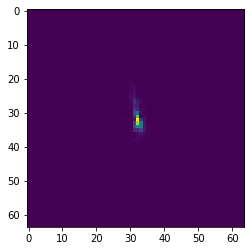

In [10]:
# PSF generator with the microscope's parameters
psf = PsfGenerator3D(psf_shape=(64,)*3, units=( 0.068519 ,0.068519, 0.2 ), na_detection=1.4, lam_detection=0.488, n=1.5) 
#psf_na_detection=1.4, psf_units=(0.068519, 0.068519,0.2), psf_n=1.5, psf_lam_detection=0.488
#--noise_mean 5,7 --noise_sigma 1.5,3 --noise_snr 21,34 –ph '../ly17_crop50.tif' -unitsxy 0.068519 -psf_lam 0.488

# Wavefront with the predicted amplitudes
wf = ZernikeWavefront(amps, order='ansi')

# Predicted PSF
h1 = psf.incoherent_psf(wf, normed=True)
print(h1.shape)

plt.imshow(h1[30])

In [13]:
# Save the predicted PSF to use it later for deconvolution
tiff.imsave(f"images/predpsf_ly17center.tif",h1)

## Open another virtual env with Flowdec

In [5]:
from skimage import exposure
from scipy import ndimage, signal
from flowdec import data as fd_data
from flowdec import psf as fd_psf
from flowdec import restoration as fd_restoration
import matplotlib.pyplot as plt
from pathlib import Path
import tifffile as tiff
import numpy as np

from datetime import datetime

from aberration.plot_metrics import crop_center

def normalize(x, pmin=3, pmax=99.8, axis=None, clip=False, eps=1e-20, dtype=np.float32):
    """Percentile-based image normalization from csbdeep
    https://github.com/CSBDeep/CSBDeep/blob/master/csbdeep/utils/utils.py
    Duplicated here because of the versions conflict"""

    mi = np.percentile(x,pmin,axis=axis,keepdims=True)
    ma = np.percentile(x,pmax,axis=axis,keepdims=True)
    
    def normalize_mi_ma(x, mi, ma, clip=False, eps=1e-20, dtype=np.float32):
        if dtype is not None:
            x   = x.astype(dtype,copy=False)
            mi  = dtype(mi) if np.isscalar(mi) else mi.astype(dtype,copy=False)
            ma  = dtype(ma) if np.isscalar(ma) else ma.astype(dtype,copy=False)
            eps = dtype(eps)

        try:
            import numexpr
            x = numexpr.evaluate("(x - mi) / ( ma - mi + eps )")
        except ImportError:
            x =                   (x - mi) / ( ma - mi + eps )

        if clip:
            x = np.clip(x,0,1)

        return x

    return normalize_mi_ma(x, mi, ma, clip=clip, eps=eps, dtype=dtype)



In [21]:
# Load the predicted PSF (= kernel for deconvolution)
kernel = tiff.imread(f"images/predpsf_ly17center.tif")

# Load the raw image to be restored
name = f"images/4wk-ly17/4wk-ly17-manual"
actual = normalize(tiff.imread(name+'.tif'))


In [22]:
# Pad kernel of size [64,64,64] to the image of size [58,222,246]
paded = np.pad(kernel,( (0,), (79,), (91,))) # simmetric padding (z, y, x)
paded = paded[3:-3]

In [23]:
# Richardson-Lucy Deconvolution
kernel = paded
data = actual
algo = fd_restoration.RichardsonLucyDeconvolver(data.ndim, pad_min=np.ones(data.ndim)).initialize()
#res = algo.run(fd_data.Acquisition(data=actual, kernel=kernel), niter=2)

res = algo.run(fd_data.Acquisition(data=actual, kernel=kernel), niter=30).data

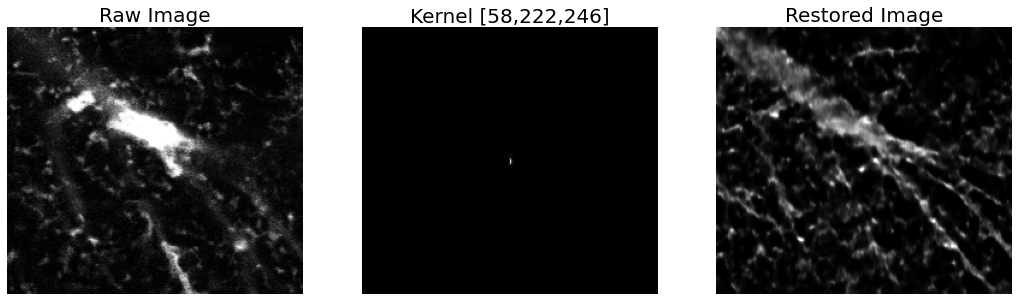

In [25]:
# Visualize images
res2 = normalize(res, pmin=10,pmax=99.9,clip=True)
actual2 = normalize(actual, pmin=10,pmax=99.9,clip=True)
# normalization can be adjusted to correct for the oversaturation of the raw image

fig, axs = plt.subplots(1, 3)
axs = axs.ravel()
fig.set_size_inches(18, 6)
# Middle slice across z
slic = 29 # int(actual.shape[0]/2)
titles = ['Raw Image','Kernel [58,222,246]', 'Restored Image']
for i, d in enumerate([actual2
                       ,kernel
                       , res2
                      ]):
    #img = exposure.adjust_gamma(d[center].max(axis=0), gamma=.2)
    axs[i].imshow(d[slic], cmap='gray')
    axs[i].set_title(titles[i],fontsize=20)
    axs[i].axis('off')

# Save to the folder with the original image
plt.savefig(name+f'restore222_slic{slic}.png')